In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
import re

from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# News headline dataset

https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection <br>

## Import data

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lisanvo13","key":"c12fa77a8c7ef1c3f5a9a56c751ac750"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [3]:
#!/bin/bash
!kaggle datasets download "rmisra/news-headlines-dataset-for-sarcasm-detection"

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.30M/3.30M [00:01<00:00, 3.66MB/s]
100% 3.30M/3.30M [00:01<00:00, 2.75MB/s]


In [4]:
# Unzip data
!mkdir "/content/news-headlines-dataset"
!unzip "/content/news-headlines-dataset-for-sarcasm-detection.zip" -d "/content/news-headlines-dataset"

Archive:  /content/news-headlines-dataset-for-sarcasm-detection.zip
  inflating: /content/news-headlines-dataset/Sarcasm_Headlines_Dataset.json  
  inflating: /content/news-headlines-dataset/Sarcasm_Headlines_Dataset_v2.json  


In [298]:
# Read JSON file into DataFrame
df = pd.read_json("/content/news-headlines-dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# EDA

In [299]:
df.dtypes

,0
is_sarcastic,int64
headline,object
article_link,object


In [300]:
# Check for NaN values
df.isnull().sum()

,0
is_sarcastic,0
headline,0
article_link,0


In [301]:
# Check for class imbalance
df["is_sarcastic"].value_counts()

,count
is_sarcastic,
0,14985
1,13634


In [302]:
# Check character count of a headline
length = len(df['headline'][0])
print(f'Length of a sample headline: {length}')

Length of a sample headline: 61


### Word count

In [303]:
# Check word count
word_count = df['headline'][0].split()
# Check word count of each headline and store in a new column
df['word_count'] = df['headline'].map(lambda rev: len(rev.split()))

print(f'Word count in a sample headline: {len(word_count)}')

Word count in a sample headline: 8


### Mean word length

In [304]:
# Calculate mean word length
df['mean_word_length'] = df['headline'].map(lambda rev: np.mean([len(word) for word in rev.split()]))

In [305]:
df.head()

,is_sarcastic,headline,article_link,word_count,mean_word_length
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,6.750000
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,5.153846
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,6.142857
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,5.625000
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,5.888889


### Remove stop words

In [306]:
# Remove stop words from each headline and store result in new column
stop_words = set(stopwords.words('english'))
df['headline_without_stopwords'] = df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [307]:
df.head()

,is_sarcastic,headline,article_link,word_count,mean_word_length,headline_without_stopwords
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,6.750000,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,5.153846,dem rep. totally nails congress falling short ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,6.142857,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,5.625000,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,5.888889,mother comes pretty close using word 'streamin...


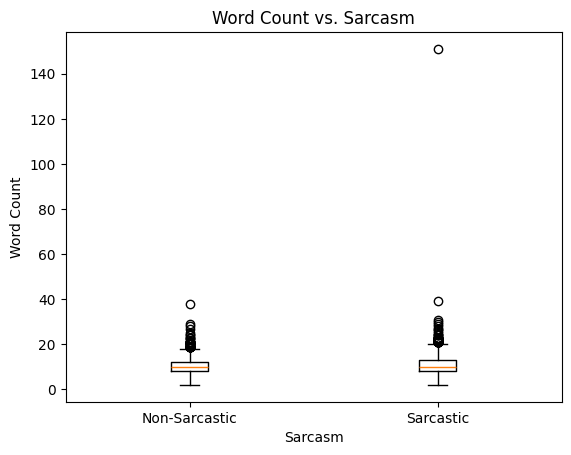

In [308]:
# @title Word Count vs. Sarcasm

import matplotlib.pyplot as plt

# Create box plot
plt.boxplot([df[df['is_sarcastic'] == 0]['word_count'],
             df[df['is_sarcastic'] == 1]['word_count']],
            labels=['Non-Sarcastic', 'Sarcastic'])

# Add labels and title
plt.xlabel('Sarcasm')
plt.ylabel('Word Count')
_ = plt.title('Word Count vs. Sarcasm')

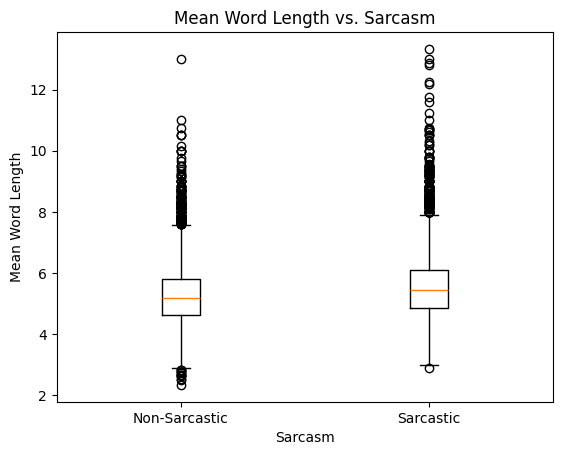

In [309]:
# @title Mean Word Length vs. Sarcasm

import matplotlib.pyplot as plt

# Create box plot
plt.boxplot([df[df['is_sarcastic'] == 0]['mean_word_length'],
             df[df['is_sarcastic'] == 1]['mean_word_length']],
            labels=['Non-Sarcastic', 'Sarcastic'])

# Add labels and title
plt.xlabel('Sarcasm')
plt.ylabel('Mean Word Length')
_ = plt.title('Mean Word Length vs. Sarcasm')

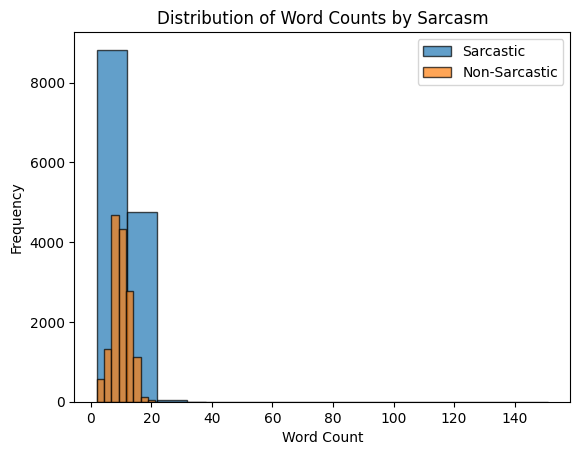

In [310]:
# @title Distribution of Word Counts by Sarcasm

import matplotlib.pyplot as plt

# Filter data for sarcastic and non-sarcastic headlines
sarcastic_headlines = df[df['is_sarcastic'] == 1]['word_count']
non_sarcastic_headlines = df[df['is_sarcastic'] == 0]['word_count']

# Create histograms
plt.hist(sarcastic_headlines, bins=15, alpha=0.7, label='Sarcastic', edgecolor='black')
plt.hist(non_sarcastic_headlines, bins=15, alpha=0.7, label='Non-Sarcastic', edgecolor='black')

# Add labels and title
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts by Sarcasm')

# Add legend
_ = plt.legend()


Text(0, 0.5, 'Word Count')

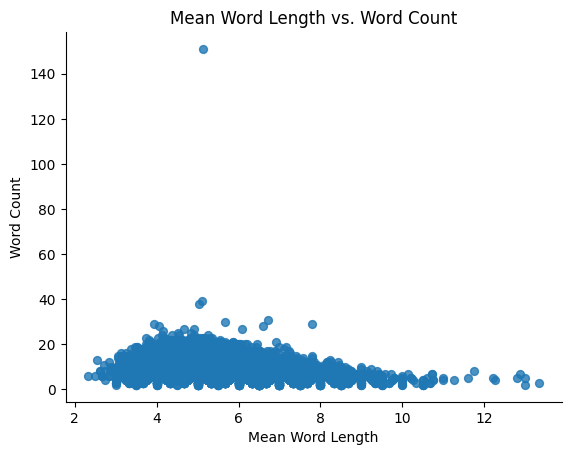

In [311]:
# @title Mean Word Length vs. Word Count

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='mean_word_length', y='word_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Mean Word Length vs. Word Count')
plt.xlabel('Mean Word Length')
plt.ylabel('Word Count')

## Mean sentence length

In [312]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [313]:
# Calculate mean sentence length
np.mean(df['headline'].map(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)])))

61.56791117788882

In [314]:
df.head()

,is_sarcastic,headline,article_link,word_count,mean_word_length,headline_without_stopwords
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,6.750000,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,5.153846,dem rep. totally nails congress falling short ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,6.142857,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,5.625000,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,5.888889,mother comes pretty close using word 'streamin...


## Most Frequently occuring N_grams (ALL)

In [315]:
# Most Frequently occuring N_grams
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['headline'])

In [316]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

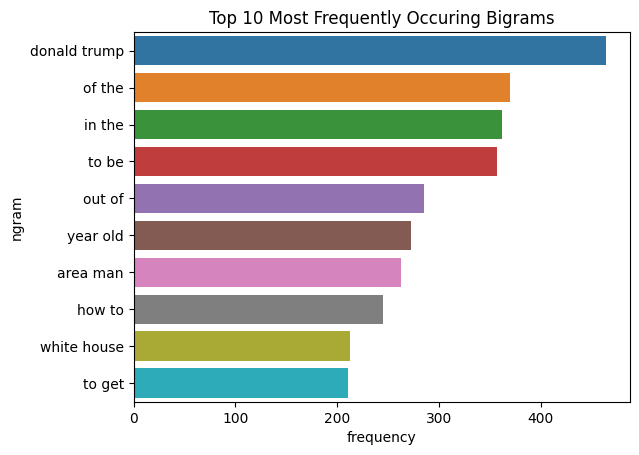

In [317]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [318]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

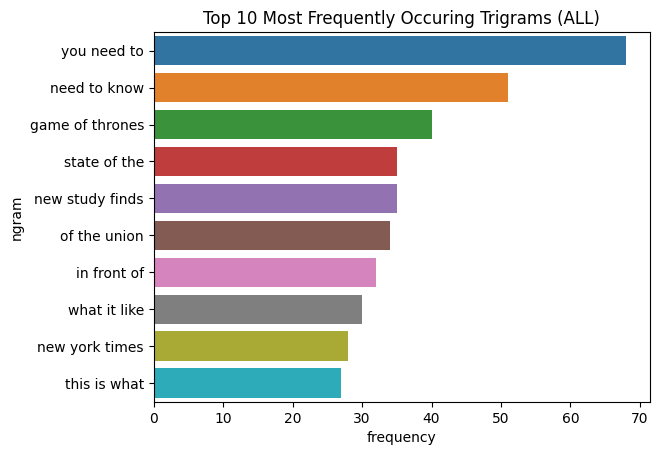

In [319]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams (ALL)')
plt.show()

### Get sarcastic dataframe and non-sarcastic dataframe

In [320]:
# Get all rows where is_sarcastic is 1
df_sarcastic = df[df['is_sarcastic'] == 1]

# Get all rows where is_sarcastic is 0
df_not_sarcastic = df[df['is_sarcastic'] == 0]

In [321]:
df_sarcastic.head(10)

,is_sarcastic,headline,article_link,word_count,mean_word_length,headline_without_stopwords
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,6.750000,thirtysomething scientists unveil doomsday clo...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,5.625000,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,5.888889,mother comes pretty close using word 'streamin...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...,13,5.846154,richard branson's global-warming donation near...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...,12,5.166667,shadow government getting large meet marriott ...
14,1,ford develops new suv that runs purely on gaso...,https://www.theonion.com/ford-develops-new-suv...,9,4.666667,ford develops new suv runs purely gasoline
16,1,area boy enters jumping-and-touching-tops-of-d...,https://www.theonion.com/area-boy-enters-jumpi...,5,11.000000,area boy enters jumping-and-touching-tops-of-d...
17,1,area man does most of his traveling by gurney,https://local.theonion.com/area-man-does-most-...,9,4.111111,area man traveling gurney
21,1,guard in video game under strict orders to rep...,https://www.theonion.com/guard-in-video-game-u...,14,4.928571,guard video game strict orders repeatedly pace...
25,1,secret service agent not so secret about being...,https://www.theonion.com/secret-service-agent-...,12,4.666667,secret service agent secret david alan grier fan


In [322]:
df_not_sarcastic.head()

,is_sarcastic,headline,article_link,word_count,mean_word_length,headline_without_stopwords
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,5.153846,dem rep. totally nails congress falling short ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,6.142857,eat veggies: 9 deliciously different recipes
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...,3,6.000000,white inheritance
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...,9,3.777778,5 ways file taxes less stress
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...,6,4.833333,lots parents know scenario


## Most Frequently occuring N_grams (SARCASTIC)

In [323]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_sarcastic['headline'])

In [324]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

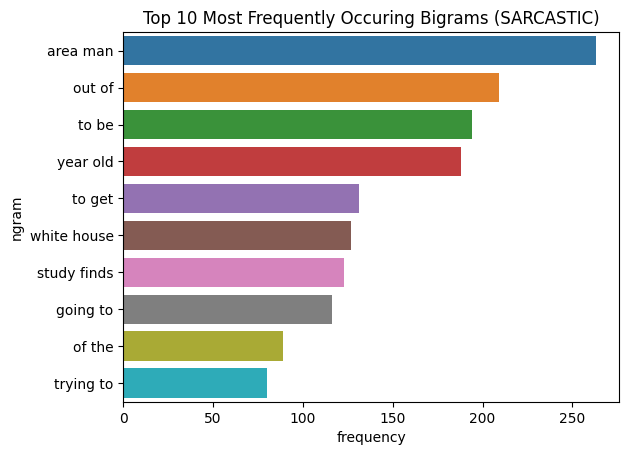

In [325]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams (SARCASTIC)')
plt.show()

In [326]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df_sarcastic['headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

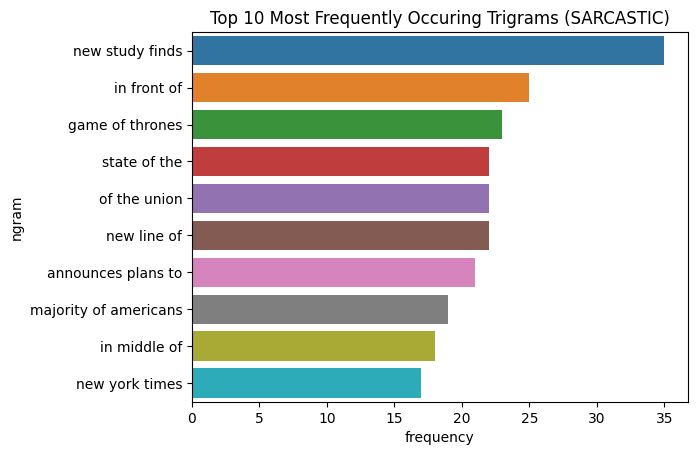

In [327]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams (SARCASTIC)')
plt.show()

## Most Frequently occuring N_grams (NOT SARCASTIC)

In [328]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_not_sarcastic['headline'])

In [329]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

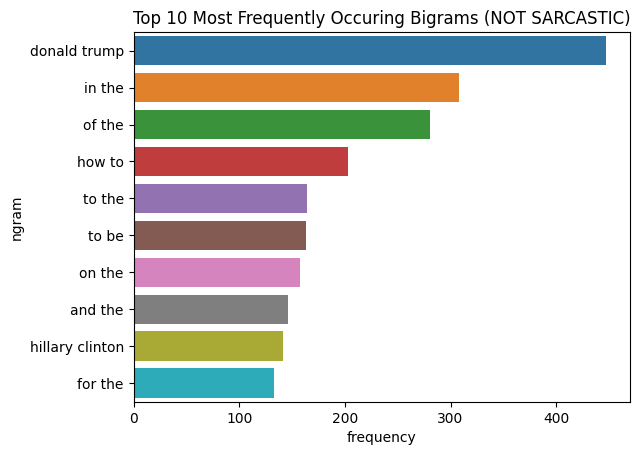

In [330]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams (NOT SARCASTIC)')
plt.show()

In [331]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df_not_sarcastic['headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

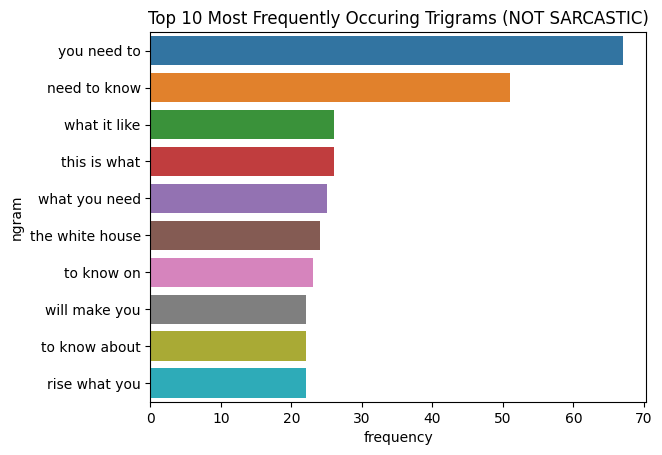

In [332]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams (NOT SARCASTIC)')
plt.show()

# Data pre-processing

In [333]:
df.head()

,is_sarcastic,headline,article_link,word_count,mean_word_length,headline_without_stopwords
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,6.750000,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,5.153846,dem rep. totally nails congress falling short ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,6.142857,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,5.625000,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,5.888889,mother comes pretty close using word 'streamin...


In [334]:
# Drop the article link, word count, mean word length, and headline without stop words
df = df.drop(['article_link', 'word_count', 'mean_word_length', 'headline_without_stopwords'], axis=1)

In [335]:
# Checking for duplicates
print(f"Number of duplicate headlines: {df.duplicated(subset='headline').sum()}")

# Drop duplicate headlines
df = df.drop_duplicates(subset='headline').reset_index(drop=True)

Number of duplicate headlines: 116


In [336]:
from textblob import TextBlob

# Function to calculate subjectivity score
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Apply the function to the 'headline' column and create a new 'subjectivity' column
df['subjectivity'] = df['headline'].apply(get_subjectivity)

In [337]:
df.shape

(28503, 3)

In [338]:
stop_words = set(stopwords.words('english'))

def clean_tokenize(text):
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return words

def clean_text(text):
    # Remove HTML tags if any
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove non-alphabetic characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub('\s+', ' ', text).strip()
    return text

In [339]:
df['clean_headline'] = df['headline'].apply(clean_text)
df[['headline', 'clean_headline']].head()

,headline,clean_headline
0,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,dem rep. totally nails why congress is falling...,dem rep totally nails why congress is falling ...
2,eat your veggies: 9 deliciously different recipes,eat your veggies deliciously different recipes
3,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,mother comes pretty close to using word 'strea...,mother comes pretty close to using word stream...


In [340]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['clean_headline'] = df['clean_headline'].apply(lemmatize_text)

# Drop the headline column
df = df.drop(['headline'], axis=1)

# Calculate total word count
df['word_count'] = df['clean_headline'].apply(lambda x: len(x.split()))

# Calculate mean word length
df['mean_word_length'] = df['clean_headline'].apply(lambda x: np.mean([len(word) for word in x.split()]))


In [341]:
# Split Data into Features and Labels
X = df.drop(['is_sarcastic'], axis=1)
y = df['is_sarcastic']

# Save Cleaned Data
df.to_csv('/content/drive/MyDrive/Colab Notebooks/aai590-capstone/cleaned_sarcasm_dataset.csv', index=False)

In [342]:
df.head()

,is_sarcastic,subjectivity,clean_headline,word_count,mean_word_length
0,1,0.000,thirtysomething scientist unveil doomsday cloc...,8,6.625000
1,0,0.525,dem rep totally nail why congress is falling s...,13,4.923077
2,0,0.600,eat your veggie deliciously different recipe,6,6.500000
3,1,0.000,inclement weather prevents liar from getting t...,8,5.625000
4,1,1.000,mother come pretty close to using word streami...,9,5.555556


In [343]:
df.head()

,is_sarcastic,subjectivity,clean_headline,word_count,mean_word_length
0,1,0.000,thirtysomething scientist unveil doomsday cloc...,8,6.625000
1,0,0.525,dem rep totally nail why congress is falling s...,13,4.923077
2,0,0.600,eat your veggie deliciously different recipe,6,6.500000
3,1,0.000,inclement weather prevents liar from getting t...,8,5.625000
4,1,1.000,mother come pretty close to using word streami...,9,5.555556


# Feature Extraction

In [344]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [345]:
X_train.head()

,subjectivity,clean_headline,word_count,mean_word_length
2826,0.498106,new law requires welfare recipient to submit s...,17,4.470588
24185,1.000000,jake tapper s grim reminder steve bannon isn t...,13,4.230769
20899,0.125000,journalist who refuse to take the same non ans...,12,4.333333
5673,0.433333,report shit last night wa trash night,7,4.428571
5262,0.333333,the importance of first responder,5,5.800000


In [346]:
y_train.head()

,is_sarcastic
2826,1
24185,0
20899,0
5673,1
5262,0


In [347]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['clean_headline'])
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['headline'])


# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test['clean_headline'])
# X_test_tfidf = tfidf_vectorizer.transform(X_test['headline'])

In [348]:
X_train_tfidf

<22802x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 213453 stored elements in Compressed Sparse Row format>

In [349]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the vocabulary size
vocab_size = 5000  # Adjust as needed

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# Fit the tokenizer on training data
tokenizer.fit_on_texts(X_train['clean_headline'])
# tokenizer.fit_on_texts(X_train['headline'])


# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_headline'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_headline'])
# X_train_seq = tokenizer.texts_to_sequences(X_train['headline'])
# X_test_seq = tokenizer.texts_to_sequences(X_test['headline'])

# Determine the maximum sequence length
max_length = max(len(seq) for seq in X_train_seq)

# Pad sequences to ensure equal length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Model Building

In [350]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [351]:
from sklearn.svm import LinearSVC

# Initialize the SVM model
svm_model = LinearSVC()

# Train the model
svm_model.fit(X_train_tfidf, y_train)

LinearSVC()

## Simple Neural Network (Multilayer Perceptron)

In [363]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization

# Define the embedding dimension
embedding_dim = 64

# Build the model add more layers and dropout
mlp_model = Sequential()
mlp_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
mlp_model.add(Flatten())
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(1, activation='sigmoid'))

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile with Adam optimiser with learning rate 0.001
mlp_model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
mlp_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [364]:
# Train the MLP model
history_mlp = mlp_model.fit(X_train_padded, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5450 - loss: 0.7771 - val_accuracy: 0.8334 - val_loss: 0.3921
Epoch 2/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8154 - loss: 0.4252 - val_accuracy: 0.8492 - val_loss: 0.3345
Epoch 3/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8803 - loss: 0.2981 - val_accuracy: 0.8593 - val_loss: 0.3317
Epoch 4/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9128 - loss: 0.2359 - val_accuracy: 0.8558 - val_loss: 0.3748
Epoch 5/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9381 - loss: 0.1733 - val_accuracy: 0.8395 - val_loss: 0.3707
Epoch 6/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9628 - loss: 0.1134 - val_accuracy: 0.8457 - val_loss: 0.6776
Epoch 7/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9664 - loss: 0.1038 - val_accuracy: 0.8409 - val_loss: 0.6215
Epoch 8/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9829 - loss: 0.0477 - val_accuracy: 0.

## Recurrent Neural Network (LSTM)

In [374]:
from tensorflow.keras.layers import LSTM, Bidirectional

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
lstm_model.add(Bidirectional(LSTM(128)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
lstm_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [375]:
# Train the LSTM model
history_lstm = lstm_model.fit(X_train_padded, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7530 - loss: 0.5055 - val_accuracy: 0.8518 - val_loss: 0.3496
Epoch 2/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8944 - loss: 0.2689 - val_accuracy: 0.8369 - val_loss: 0.3656
Epoch 3/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9208 - loss: 0.1927 - val_accuracy: 0.8518 - val_loss: 0.3814
Epoch 4/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9443 - loss: 0.1368 - val_accuracy: 0.8444 - val_loss: 0.4746
Epoch 5/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9593 - loss: 0.1079 - val_accuracy: 0.8400 - val_loss: 0.5944
Epoch 6/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9740 - loss: 0.0770 - val_accuracy: 0.8365 - val_loss: 0.7023


# Evaluation of all 3 Models

Logistic Regression Performance:
Accuracy: 0.8349
Precision: 0.8211
Recall: 0.8251
F1-score: 0.8231

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.85      0.84      0.85      3048
    Sarcastic       0.82      0.83      0.82      2653

     accuracy                           0.83      5701
    macro avg       0.83      0.83      0.83      5701
 weighted avg       0.84      0.83      0.83      5701



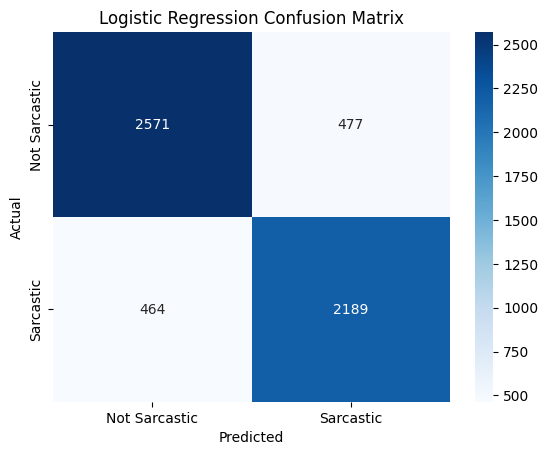

In [365]:
# Logistic Regression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Predict on test data
y_pred_lr = lr_model.predict(X_test_tfidf)

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

SVM Performance:
Accuracy: 0.8258
Precision: 0.8153
Recall: 0.8089
F1-score: 0.8121

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.83      0.84      0.84      3048
    Sarcastic       0.82      0.81      0.81      2653

     accuracy                           0.83      5701
    macro avg       0.83      0.82      0.82      5701
 weighted avg       0.83      0.83      0.83      5701



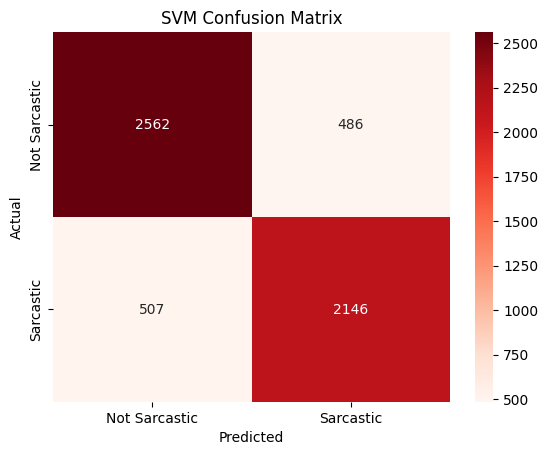

In [366]:
# SVM

# Predict on test data
y_pred_svm = svm_model.predict(X_test_tfidf)

# Calculate evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("SVM Performance:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM Confusion Matrix')
plt.show()

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8527 - loss: 0.3500
MLP Test Accuracy: 0.8539
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report for MLP:
               precision    recall  f1-score   support

Not Sarcastic       0.86      0.87      0.86      3048
    Sarcastic       0.85      0.83      0.84      2653

     accuracy                           0.85      5701
    macro avg       0.85      0.85      0.85      5701
 weighted avg       0.85      0.85      0.85      5701



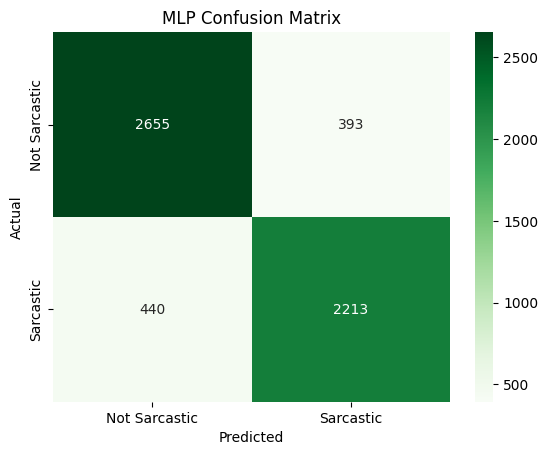

In [367]:
# Simple Neural Network (MLP)

# Evaluate the MLP model on test data
loss_mlp, accuracy_mlp = mlp_model.evaluate(X_test_padded, y_test)
print(f"MLP Test Accuracy: {accuracy_mlp:.4f}")

# Predict probabilities
y_pred_prob_mlp = mlp_model.predict(X_test_padded)
y_pred_mlp = (y_pred_prob_mlp > 0.5).astype(int)

# Classification Report
print("\nClassification Report for MLP:")
print(classification_report(y_test, y_pred_mlp, target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('MLP Confusion Matrix')
plt.show()

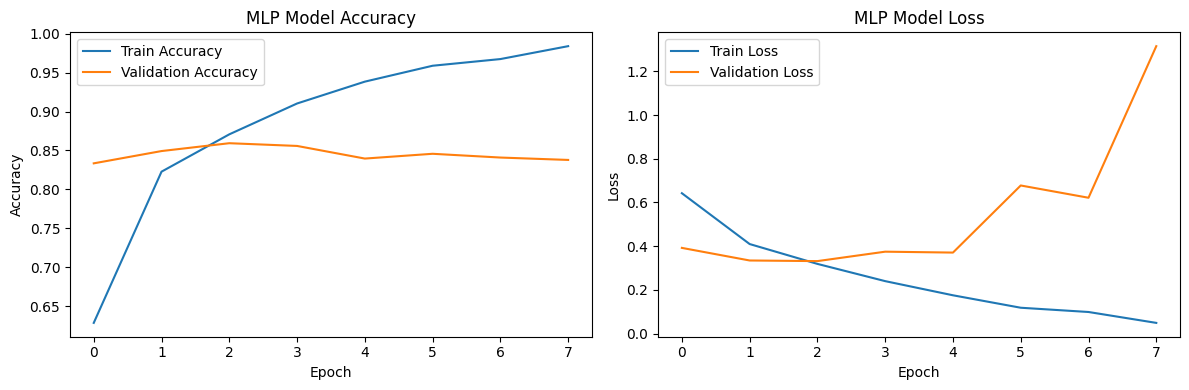

In [368]:
# Plot accuracy over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8453 - loss: 0.3377
LSTM Test Accuracy: 0.8530
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report for LSTM:
               precision    recall  f1-score   support

Not Sarcastic       0.87      0.86      0.86      3048
    Sarcastic       0.84      0.85      0.84      2653

     accuracy                           0.85      5701
    macro avg       0.85      0.85      0.85      5701
 weighted avg       0.85      0.85      0.85      5701



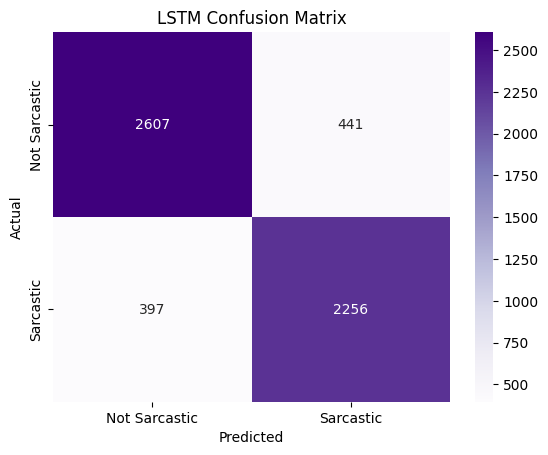

In [369]:
# LSTM Model

# Evaluate the LSTM model on test data
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test_padded, y_test)
print(f"LSTM Test Accuracy: {accuracy_lstm:.4f}")

# Predict probabilities
y_pred_prob_lstm = lstm_model.predict(X_test_padded)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

# Classification Report
print("\nClassification Report for LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('LSTM Confusion Matrix')
plt.show()

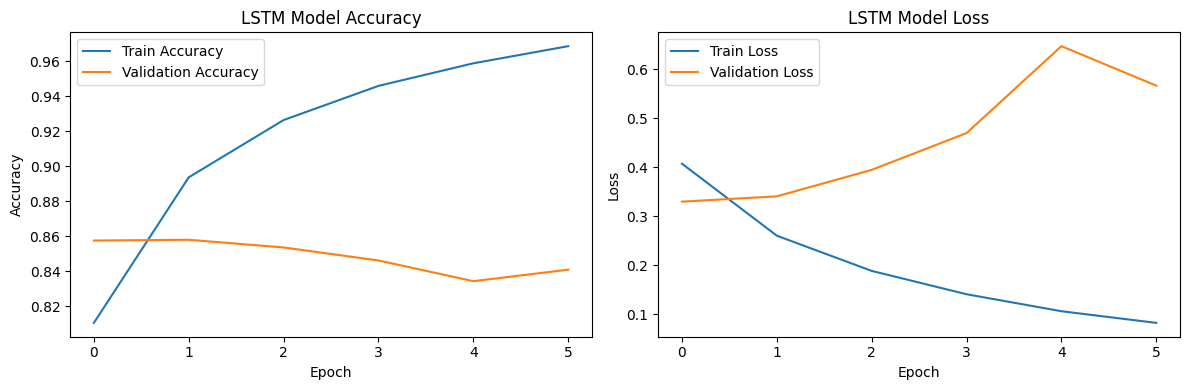

In [370]:
# Plot accuracy over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Analysis and Comparison

In [371]:
# After training and evaluating all models, compare their performance metrics to determine which model performs best on the sarcasm detection task.

# Create a summary table
import pandas as pd

performance_data = {
    'Model': ['Logistic Regression', 'SVM', 'MLP', 'LSTM'],
    'Accuracy': [accuracy_lr, accuracy_svm, accuracy_mlp, accuracy_lstm],
    'Precision': [precision_lr, precision_svm, precision_score(y_test, y_pred_mlp), precision_score(y_test, y_pred_lstm)],
    'Recall': [recall_lr, recall_svm, recall_score(y_test, y_pred_mlp), recall_score(y_test, y_pred_lstm)],
    'F1-score': [f1_lr, f1_svm, f1_score(y_test, y_pred_mlp), f1_score(y_test, y_pred_lstm)]
}

performance_df = pd.DataFrame(performance_data)
print(performance_df)

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.834941   0.821080  0.825104  0.823087
1                  SVM  0.825820   0.815350  0.808896  0.812110
2                  MLP  0.853885   0.849194  0.834150  0.841605
3                 LSTM  0.853008   0.836485  0.850358  0.843364
